<h1> Spotify Skip Prediction Dataset </h1>
This dataset comes in two sets. The first set is details about 'sessions': chunks of songs a user listens to in one go, and what songs were listened to. The second set details the song's features. <br>
Our analysis will include just the mini set availible on AI Crowd. The input we are using is an augmented table that combines the user session data and the song features data. 
There are 167880 entires and 50 total features. Only 47 features will be used. 

<h3>References</h3>
We'd like to recognize that due to enormity of this dataset and the complexity of how it was stored (in multiple seperate and unorganized .csv files), we did use online references to decide on our stack and how we would approach the data. <br>
We used the following a examples: <br> <br>
<li> <a>https://github.com/a-poor/spotify-skip-prediction/blob/master/README.md</a>
<br><i>Used for template tech stack and reorganize dataset. </i>

<h2>Import Libraries and Datasets</h2>

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# load both csv files into dataframes
log_df = pd.read_csv('log_mini.csv') # user log
tf_df  = pd.read_csv('tf_mini.csv')  # track features
 
# rename and merge the two data frames so that the 
log_df = log_df.rename(columns={'track_id_clean': 'track_id'})

# perform a merge so that song information is attached to the user information
og_data_df = pd.merge(log_df, tf_df, on='track_id')

# Save the merged DataFrame to a new CSV file
og_data_df.to_csv('merged_file.csv', index=False)
data_df = og_data_df

C:\Users\booke\AppData\Local\Temp\ipykernel_93384\475007126.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
print(data_df.head(1))
print(data_df.shape)

                               session_id  session_position  session_length  \
0  0_00006f66-33e5-4de7-a324-2d18e439fc1e                 1              20   

                                 track_id  skip_1  skip_2  skip_3  \
0  t_0479f24c-27d2-46d6-a00c-7ec928f2b539   False   False   False   

   not_skipped  context_switch  no_pause_before_play  ...  time_signature  \
0         True               0                     0  ...               4   

    valence  acoustic_vector_0  acoustic_vector_1  acoustic_vector_2  \
0  0.152255          -0.815775           0.386409            0.23016   

   acoustic_vector_3 acoustic_vector_4  acoustic_vector_5 acoustic_vector_6  \
0           0.028028         -0.333373           0.015452          -0.35359   

  acoustic_vector_7  
0          0.205826  

[1 rows x 50 columns]
(167880, 50)


# Reorganizing the Data
We decided to select the the variable skip_3 as our 'y' variable. The 'skip_3' feautre represents when a 

In [3]:
# Making a 'skipped' feature for whether a song has been skipped or not, regardless of how fast
data_df['skipped'] = (data_df.skip_3 | data_df.skip_2 | data_df.skip_1).astype('int32')

# Make 'skipped' column our 'y' value for prediction
y_df = data_df['skipped']

data_df = data_df.drop(columns=["skip_1", "skip_2", "skip_3", "not_skipped"], axis=1)
#Optional print just to check features
print(data_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167880 entries, 0 to 167879
Data columns (total 47 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   session_id                       167880 non-null  object 
 1   session_position                 167880 non-null  int64  
 2   session_length                   167880 non-null  int64  
 3   track_id                         167880 non-null  object 
 4   context_switch                   167880 non-null  int64  
 5   no_pause_before_play             167880 non-null  int64  
 6   short_pause_before_play          167880 non-null  int64  
 7   long_pause_before_play           167880 non-null  int64  
 8   hist_user_behavior_n_seekfwd     167880 non-null  int64  
 9   hist_user_behavior_n_seekback    167880 non-null  int64  
 10  hist_user_behavior_is_shuffle    167880 non-null  bool   
 11  hour_of_day                      167880 non-null  int64  
 12  da

## Dealing with Non-Float Values
The IDs of the songs and the users are strings. We've chosen to completely drop these values. While it is reasonable to assume they impact the predicted value, we opt to focus on more generally modeling whether a song will be skipped or not as opposed to whether a song will be skipped or not depending on previous skips and sessions since there are 10,000 sessions in the mini dataset, a value we are not sure how to deal with considering the reasources we have.

###

In [4]:
# drop id values
data_df = data_df.drop(columns=["session_id", "track_id"], axis=1)

In [5]:
# fix the session_date column into seperate parts. dropping day. 
data_df['session_year'] = pd.to_datetime(data_df['date']).dt.year
data_df['session_month'] = pd.to_datetime(data_df['date']).dt.month
# data_df['day'] = pd.to_datetime(data_df['date']).dt.day
data_df['session_day_of_week'] = pd.to_datetime(data_df['date']).dt.dayofweek
#print(data_df.head(3))
data_df = data_df.drop('date', axis=1)
print(data_df.head(3))



   session_position  session_length  context_switch  no_pause_before_play  \
0                 1              20               0                     0   
1                 2              20               0                     1   
2                 3              20               0                     1   

   short_pause_before_play  long_pause_before_play  \
0                        0                       0   
1                        0                       0   
2                        0                       0   

   hist_user_behavior_n_seekfwd  hist_user_behavior_n_seekback  \
0                             0                              0   
1                             0                              0   
2                             0                              0   

   hist_user_behavior_is_shuffle  hour_of_day  ...  acoustic_vector_2  \
0                           True           16  ...           0.230160   
1                           True           16  ...           0.

In [6]:
data_df['premium'] = data_df['premium'].astype(int)
# print(data_df['premium'].head(5))

# hist_user_behavior_is_shuffle
data_df['hist_user_behavior_is_shuffle'] = data_df['hist_user_behavior_is_shuffle'].astype(int)
# print(data_df['hist_user_behavior_is_shuffle'].head(5))

data_df['mode'] = data_df['mode'].map({'major':1, 'minor':0})
# print(data_df['mode'].head(5))


### Categorical Variables
The following variables were categorical in nature:
* time_signature
* key_signature
* context_type
* hist_user_behavior_reason_start	
* hist_user_behavior_reason_end
<br><br>Lets analyze how many types of values are in each column to determine whether one-hot encoding or ordinal encoding is more advantageous. 

In [7]:
list = ['time_signature', 'key', 'context_type', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end' ]

for col in list:
    unique_values = data_df[col].unique()
    print(col, ": ", unique_values)

time_signature :  [4 5 3 1 0]
key :  [ 1  7 10  8  6  5  4  2  0  3  9 11]
context_type :  ['editorial_playlist' 'user_collection' 'radio' 'personalized_playlist'
 'catalog' 'charts']
hist_user_behavior_reason_start :  ['trackdone' 'fwdbtn' 'backbtn' 'clickrow' 'appload' 'playbtn' 'remote'
 'trackerror' 'endplay']
hist_user_behavior_reason_end :  ['trackdone' 'fwdbtn' 'backbtn' 'endplay' 'logout' 'remote' 'clickrow']


### Analyzing Unique Values
For *time signature*, due to the ordered nature, we will use *ordinal* encoding.
For *context_type*, *key*, *hist_user_behavior_reason_start*, and *hist_user_behavior_reason_end* we will use *one-hot* encoding as their seems to be no inheret order to the values. 

Let's make the changes now!

## One-Hot Encoding


In [8]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

encoder = OneHotEncoder()

categorical_features = ['context_type', 'hist_user_behavior_reason_start', 'hist_user_behavior_reason_end', 'key']
encoded_data = encoder.fit_transform(data_df[categorical_features])

encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoder.get_feature_names_out(categorical_features))

data_df = pd.concat([data_df.reset_index(drop=True), encoded_df], axis=1)

data_df.drop(categorical_features, axis=1, inplace=True)

# print(data_df.head(2))
# print(data_df.columns)


In [9]:
# from sklearn.preprocessing import OrdinalEncoder

# # Assuming 'df' is your dataframe and 'feature_columns' is a list of columns to be encoded
# encoder = OrdinalEncoder()

# # Fit-transform the specified columns and replace the original values with encoded values
# data_df[feature_columns] = encoder.fit_transform(data_df[feature_columns])

### Check for Missing Values

In [10]:
# check for missing values
missing_values = data_df.isnull().sum()

# display columns with missing values and counts
print(missing_values[missing_values > 0])

data_df = data_df.drop(columns=["skipped"], axis=1)
# print(data_df.columns)

Series([], dtype: int64)


### Split Data into Test and Training Sets

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data_df, y_df, test_size=0.2, random_state=42)

In [12]:
# value_counts = data_df['session_id'].value_counts()

# # Display the counts of each unique value in the column
# print(value_counts)

# Model #1: Logistic Regression
Our first model will be a logistic regression model using sklearn's implementation. 


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [14]:
model = LogisticRegression(max_iter=10000)

model.fit(X_train, y_train)

predictions = model.predict(X_test)
print(predictions)

[0 0 1 ... 1 0 1]


In [15]:
# accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

Accuracy: 0.9809685489635454


In [16]:
# Assuming 'model' is your trained logistic regression model
coefficients = model.coef_

# Assuming 'X_train' contains the feature data
feature_names = X_train.columns

# Pairing coefficients with feature names
coefficients_table = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients[0]})

# Sorting by coefficient magnitude
coefficients_table['Abs_Coefficient'] = abs(coefficients_table['Coefficient'])
coefficients_table = coefficients_table.sort_values(by='Abs_Coefficient', ascending=False)

# Print or display the coefficients table
print(coefficients_table)

                                    Feature  Coefficient  Abs_Coefficient
63  hist_user_behavior_reason_end_trackdone    -6.987080         6.987080
57    hist_user_behavior_reason_end_backbtn     2.705056         2.705056
6              hist_user_behavior_n_seekfwd     2.483624         2.483624
48  hist_user_behavior_reason_start_appload     1.987874         1.987874
7             hist_user_behavior_n_seekback    -1.490807         1.490807
..                                      ...          ...              ...
73                                    key_9     0.005091         0.005091
12                             release_year     0.003778         0.003778
11                                 duration     0.002935         0.002935
28                                    tempo     0.001666         0.001666
39                             session_year    -0.000859         0.000859

[76 rows x 3 columns]


In [17]:
predictions = model.predict(X_test)
# print(X_test.head)

mse = mean_squared_error(y_test, predictions)
print("Mean Squared Error:", mse)

NameError: name 'mean_squared_error' is not defined

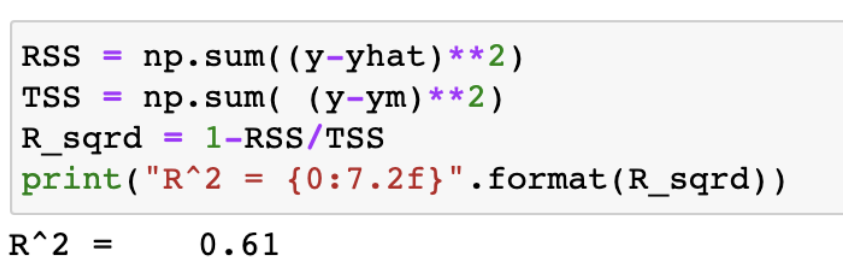

In [18]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# calculating accuracy
accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)

# printing confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
print("Confusion Matrix:")
print(conf_matrix)

# printing classification report
class_report = classification_report(y_test, predictions)
print("Classification Report:")
print(class_report)

Accuracy: 0.9809685489635454
Confusion Matrix:
[[11320   483]
 [  156 21617]]
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     11803
           1       0.98      0.99      0.99     21773

    accuracy                           0.98     33576
   macro avg       0.98      0.98      0.98     33576
weighted avg       0.98      0.98      0.98     33576



In [19]:

# calculating R^2
RSS = np.sum((y_test - predictions)**2)
print(RSS)
TSS = np.sum((y_test - (np.mean(y_test)))**2)
print(TSS)
R_sqrd = 1 - (RSS/TSS)
print("R^2 = {0:7.2f}".format(R_sqrd))

639
7653.8813140338325
R^2 =    0.92


# Model #3: Neural Network

In [20]:

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [21]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])


C:\Users\booke\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [23]:
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 4s 690us/step - accuracy: 0.7586 - loss: 1.1695 - val_accuracy: 0.9613 - val_loss: 0.1558
Epoch 2/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 3s 634us/step - accuracy: 0.9370 - loss: 0.3098 - val_accuracy: 0.8936 - val_loss: 0.2867
Epoch 3/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 3s 686us/step - accuracy: 0.9478 - loss: 0.3209 - val_accuracy: 0.9788 - val_loss: 0.1806
Epoch 4/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 3s 635us/step - accuracy: 0.9540 - loss: 0.2544 - val_accuracy: 0.9779 - val_loss: 0.2304
Epoch 5/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 3s 670us/step - accuracy: 0.9691 - loss: 0.1631 - val_accuracy: 0.9806 - val_loss: 0.0961
Epoch 6/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 3s 635us/step - accuracy: 0.9717 - loss: 0.1348 - val_accuracy: 0.9794 - val_loss: 0.0958
Epoch 7/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 3s 643us/step - accuracy: 0.9776 - loss: 0.1112 - val_accuracy: 0.9805 - val_loss: 0.0961
Epoch 8/10
4197/4197 ━━━━━━━━━━━━━━━━━━━━ 3s 638us/step - accuracy: 0.9777 -

In [24]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)


1050/1050 ━━━━━━━━━━━━━━━━━━━━ 0s 432us/step - accuracy: 0.9808 - loss: 0.0829
Test Accuracy: 0.9808791875839233


# Model #2: SVM

In [25]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Create a linear SVM classifier
svm_classifier = SVC(kernel='linear', verbose=True)

# Train the classifier
svm_classifier.fit(X_train, y_train)

# Make predictions on the test data
svm_predictions = svm_classifier.predict(X_test)

# Calculate accuracy
svm_accuracy = accuracy_score(y_test, svm_predictions)
print("SVM Accuracy:", svm_accuracy)


[LibSVM]SVM Accuracy: 0.9800452704312604
